# Step 1: Capture Voice and store it for later processing.

In [8]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
from collections import deque
from datetime import datetime

def record_until_silence(threshold=500, silence_duration=1.0, sample_rate=44100, max_duration=10):
    # Input validation
    if not all(isinstance(x, (int, float)) for x in [threshold, silence_duration, sample_rate, max_duration]):
        raise ValueError("All parameters must be numeric")
    if max_duration <= 0 or silence_duration <= 0:
        raise ValueError("Duration parameters must be positive")
    
    print("Initializing audio capture...")
    buffer = deque()  # More efficient than list for continuous appending
    silence_samples = int(silence_duration * sample_rate)
    silence_counter = 0
    peak_amplitude = 0
    
    def callback(indata, frames, time, status):
        nonlocal silence_counter, peak_amplitude
        if status:
            print(f'Status: {status}')
        
        current_amplitude = np.abs(indata).max()
        peak_amplitude = max(peak_amplitude, current_amplitude)
        buffer.append(indata.copy())
        
        # Check if the audio is below the threshold (silence)
        if current_amplitude < threshold:
            silence_counter += frames
        else:
            silence_counter = 0
            
        # Visual feedback of audio level
        if frames % (sample_rate // 2) == 0:  # Update twice per second
            print(f"Audio level: {'|' * int(current_amplitude/threshold)}")
            
        if silence_counter >= silence_samples:
            raise sd.CallbackStop
    
    try:
        with sd.InputStream(samplerate=sample_rate, channels=1, 
                          dtype=np.int16, callback=callback) as stream:
            print("Recording started... Speak now")
            sd.sleep(int(max_duration * 1000))
    except sd.CallbackStop:
        print("\nRecording stopped due to silence")
    except sd.CallbackAbort:
        print("\nRecording aborted due to device error")
    except Exception as e:
        print(f"\nError during recording: {str(e)}")
        return None, None

    if len(buffer) == 0:
        print("No audio recorded!")
        return None, None

    print(f"Peak amplitude detected: {peak_amplitude}")
    
    # Generate unique filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'recorded_audio_{timestamp}.wav'
    
    try:
        audio = np.concatenate(buffer, axis=0)
        wav.write(filename, sample_rate, audio)
        print(f"Audio saved as: {filename}")
        return audio, sample_rate
    except Exception as e:
        print(f"Error saving audio: {str(e)}")
        return None, None

In [9]:
# Record audio until silence is detected
audio_data, sr = record_until_silence(threshold=300, silence_duration=2.0, max_duration=30)
if audio_data is not None and sr is not None:
    print(f"Successfully recorded {len(audio_data)/sr:.2f} seconds of audio")


Initializing audio capture...
Recording started... Speak now
Recording started... Speak now
Peak amplitude detected: 25225
Audio saved as: recorded_audio_20250704_210236.wav
Successfully recorded 7.50 seconds of audio
Peak amplitude detected: 25225
Audio saved as: recorded_audio_20250704_210236.wav
Successfully recorded 7.50 seconds of audio


# Step 2: Process audio and detect pattern and build memory support.

Processing audio with duration: 7.50 seconds
Extracting audio features...
Finding matching patterns...
New pattern detected! ID: pattern_20250704_213329
Memory saved to audio_memory.pkl
Visualizing audio...


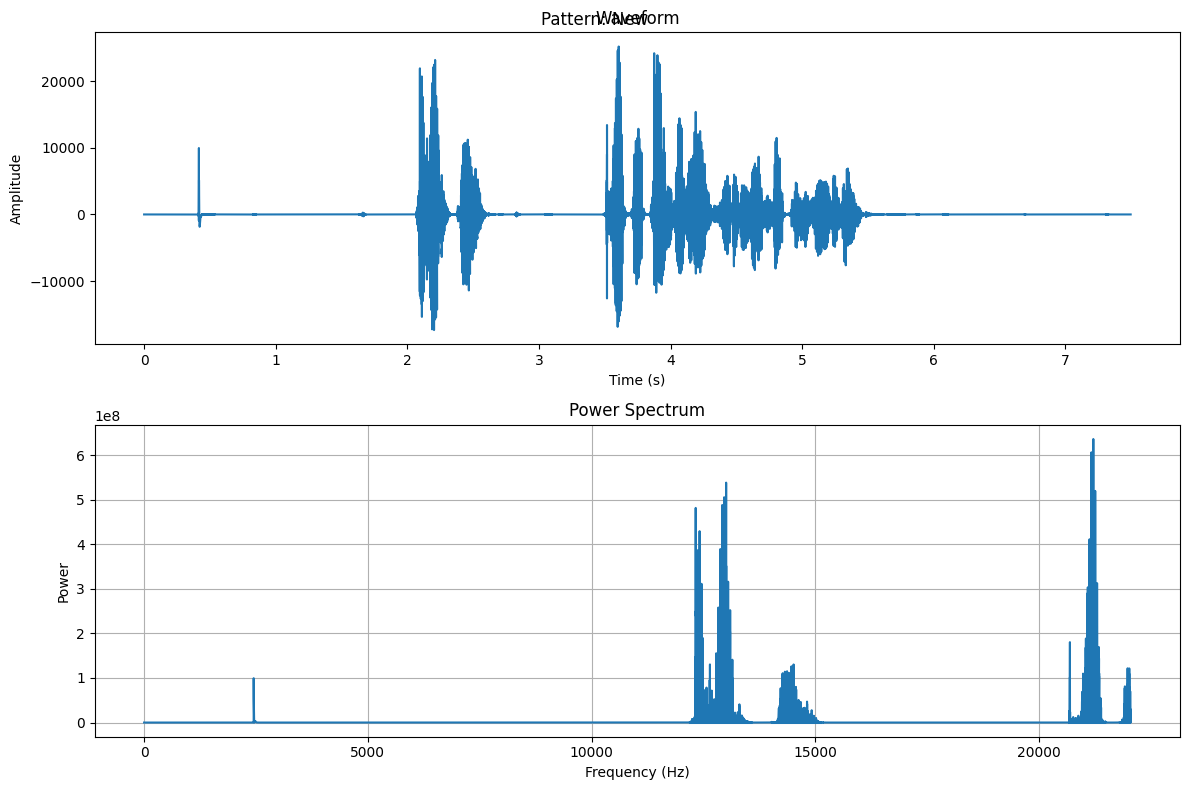

Processed audio and extracted 22 features


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime

class AudioMemory:
    def __init__(self, memory_file='audio_memory.pkl'):
        self.memory_file = memory_file
        self.memories = self._load_memory()
        
    def _load_memory(self):
        if os.path.exists(self.memory_file):
            try:
                with open(self.memory_file, 'rb') as f:
                    return pickle.load(f)
            except Exception as e:
                print(f"Error loading memory: {e}")
                return {}
        return {}
    
    def save_memory(self):
        try:
            with open(self.memory_file, 'wb') as f:
                pickle.dump(self.memories, f)
            print(f"Memory saved to {self.memory_file}")
        except Exception as e:
            print(f"Error saving memory: {e}")
    
    def add_pattern(self, pattern_id, features, timestamp=None):
        if timestamp is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        self.memories[pattern_id] = {
            'features': features,
            'timestamp': timestamp,
            'count': 1
        }
        self.save_memory()
    
    def update_pattern(self, pattern_id, features):
        if pattern_id in self.memories:
            # Update with moving average
            old_features = self.memories[pattern_id]['features']
            
            # Weighted average (gives more weight to established patterns)
            alpha = 0.8  # Weight for existing pattern
            updated_features = alpha * old_features + (1-alpha) * features
            
            self.memories[pattern_id]['features'] = updated_features
            self.memories[pattern_id]['count'] += 1
            self.memories[pattern_id]['last_seen'] = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.save_memory()
            return True
        return False
    
    def find_matching_pattern(self, features, threshold=0.85):
        if not self.memories:
            return None, 0
        
        best_match = None
        best_score = -1
        
        for pattern_id, data in self.memories.items():
            stored_features = data['features']
            
            # Calculate cosine similarity
            similarity = np.dot(features, stored_features) / (np.linalg.norm(features) * np.linalg.norm(stored_features))
            
            if similarity > threshold and similarity > best_score:
                best_score = similarity
                best_match = pattern_id
        
        return best_match, best_score if best_match else (None, 0)
    
    def get_all_patterns(self):
        return self.memories

def extract_audio_features(audio_data, sr, n_bands=20):
    """Extract simple audio features without using librosa"""
    try:
        # Convert to mono if needed
        if len(audio_data.shape) > 1 and audio_data.shape[1] > 1:
            audio_data = np.mean(audio_data, axis=1)
        
        # Normalize audio
        audio_data = audio_data / np.max(np.abs(audio_data))
        
        # Calculate FFT using numpy instead of scipy
        n = len(audio_data)
        yf = np.fft.fft(audio_data)
        # Take only the first half (positive frequencies)
        amplitude_spectrum = np.abs(yf[:n//2])
        
        # Get frequency bands (simple version of MFCCs)
        # Divide the spectrum into bands and take the mean of each band
        band_size = len(amplitude_spectrum) // n_bands
        bands = []
        for i in range(n_bands):
            start = i * band_size
            end = (i + 1) * band_size if i < n_bands - 1 else len(amplitude_spectrum)
            bands.append(np.mean(amplitude_spectrum[start:end]))
        
        # Add time domain features
        # Count zero crossings
        zero_crossings = len(np.where(np.diff(np.signbit(audio_data)))[0]) / len(audio_data)
        # Calculate RMS
        rms = np.sqrt(np.mean(np.square(audio_data)))
        
        # Create feature array
        feature_list = bands.copy()
        feature_list.append(zero_crossings)
        feature_list.append(rms)
        features = np.array(feature_list)
        
        # Normalize features
        normalized_features = features / np.linalg.norm(features)
        
        return normalized_features
    
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

def visualize_audio(audio_data, sr, title="Audio Analysis"):
    """Visualize audio waveform and simple spectrum"""
    plt.figure(figsize=(12, 8))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    time = np.arange(0, len(audio_data)) / sr
    plt.plot(time, audio_data)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Plot simple spectrum using scipy.signal.spectrogram instead of raw FFT
    plt.subplot(2, 1, 2)
    
    # Use simple power spectrum calculation
    freqs = np.fft.fftfreq(len(audio_data), 1/sr)
    power_spectrum = np.abs(np.fft.fft(audio_data))**2
    
    # Only plot positive frequencies up to Nyquist frequency
    positive_freq_mask = freqs >= 0
    plt.plot(freqs[positive_freq_mask], power_spectrum[positive_freq_mask])
    
    plt.title("Power Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

def process_audio(audio_data, sr, memory=None, visualize=True):
    """Process audio data, extract features, and match against memory"""
    if memory is None:
        memory = AudioMemory()
    
    print("Extracting audio features...")
    # Extract features
    features = extract_audio_features(audio_data, sr)
    if features is None:
        return None
    
    print("Finding matching patterns...")
    # Find matching pattern
    pattern_match, similarity_score = memory.find_matching_pattern(features)
    
    if pattern_match:
        print(f"Matched pattern: {pattern_match} with similarity score: {similarity_score:.4f}")
        # Update existing pattern
        memory.update_pattern(pattern_match, features)
    else:
        # Create new pattern ID
        new_pattern_id = f"pattern_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        print(f"New pattern detected! ID: {new_pattern_id}")
        memory.add_pattern(new_pattern_id, features)
    
    # Visualize if requested
    if visualize:
        print("Visualizing audio...")
        visualize_audio(audio_data, sr, title=f"Pattern: {pattern_match if pattern_match else 'New'}")
    
    return features

# Initialize memory system
memory_system = AudioMemory()

# Process the recorded audio if available
if 'audio_data' in globals() and 'sr' in globals() and audio_data is not None and sr is not None:
    print(f"Processing audio with duration: {len(audio_data)/sr:.2f} seconds")
    features = process_audio(audio_data, sr, memory=memory_system)
    if features is not None:
        print(f"Processed audio and extracted {len(features)} features")
else:
    print("No audio data available. Please record audio in Step 1 first.")
